In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=10, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    adadelta = Adadelta(lr=1e-3, rho=0.95, epsilon=1e-6, decay=1e-6)
    model.compile(loss='binary_crossentropy',
                    optimizer=adadelta,
                    metrics=['accuracy'])
    
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=sgd,
#                   metrics=['accuracy'])
    return model



In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=10
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=50,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/50
24/24 [==============================] - 18s 760ms/step - loss: 0.9204 - acc: 0.5175 - val_loss: 0.6633 - val_acc: 0.6296
Epoch 2/50
24/24 [==============================] - 13s 552ms/step - loss: 0.7795 - acc: 0.5804 - val_loss: 0.5711 - val_acc: 0.7469
Epoch 3/50
24/24 [==============================] - 13s 554ms/step - loss: 0.7338 - acc: 0.6038 - val_loss: 0.5015 - val_acc: 0.7469
Epoch 4/50
24/24 [==============================] - 13s 553ms/step - loss: 0.6466 - acc: 0.6431 - val_loss: 0.4436 - val_acc: 0.8025
Epoch 5/50
24/24 [==============================] - 13s 555ms/step - loss: 0.6073 - acc: 0.6658 - val_loss: 0.3965 - val_acc: 0.8457
Epoch 6/50
24/24 [==============================] - 13s 558ms/step - loss: 0.5586 - acc: 0.7019 - val_loss: 0.3657 - val_acc: 0.8395
Epoch 7/50
24/24 [==============================] - 12s 509ms/step - loss: 0.5111 - acc: 0.7358 - val_loss: 0.3818 - val_acc: 0.8086
Epoch 8/50
24/24 [=======================

24/24 [==============================] - 14s 564ms/step - loss: 0.3785 - acc: 0.8278 - val_loss: 0.3103 - val_acc: 0.8385
Epoch 14/50
24/24 [==============================] - 12s 516ms/step - loss: 0.3663 - acc: 0.8330 - val_loss: 0.3346 - val_acc: 0.8075
Epoch 15/50
24/24 [==============================] - 14s 567ms/step - loss: 0.3501 - acc: 0.8412 - val_loss: 0.2887 - val_acc: 0.8696
Epoch 16/50
24/24 [==============================] - 12s 516ms/step - loss: 0.3487 - acc: 0.8447 - val_loss: 0.3457 - val_acc: 0.8261
Epoch 17/50
24/24 [==============================] - 12s 517ms/step - loss: 0.3192 - acc: 0.8545 - val_loss: 0.2958 - val_acc: 0.8323
Epoch 18/50
24/24 [==============================] - 12s 516ms/step - loss: 0.3210 - acc: 0.8585 - val_loss: 0.2898 - val_acc: 0.8509
Epoch 19/50
24/24 [==============================] - 14s 566ms/step - loss: 0.3149 - acc: 0.8627 - val_loss: 0.2695 - val_acc: 0.8944
Epoch 20/50
24/24 [==============================] - 12s 516ms/step - loss

24/24 [==============================] - 13s 558ms/step - loss: 0.3360 - acc: 0.8593 - val_loss: 0.2578 - val_acc: 0.8696
Epoch 24/50
24/24 [==============================] - 12s 515ms/step - loss: 0.3313 - acc: 0.8521 - val_loss: 0.2817 - val_acc: 0.8571
Epoch 25/50
24/24 [==============================] - 12s 515ms/step - loss: 0.3190 - acc: 0.8581 - val_loss: 0.2685 - val_acc: 0.8509
Epoch 26/50
24/24 [==============================] - 12s 515ms/step - loss: 0.3429 - acc: 0.8547 - val_loss: 0.2676 - val_acc: 0.8758
Epoch 27/50
24/24 [==============================] - 14s 565ms/step - loss: 0.3352 - acc: 0.8538 - val_loss: 0.2453 - val_acc: 0.8820
Epoch 28/50
24/24 [==============================] - 12s 516ms/step - loss: 0.3321 - acc: 0.8420 - val_loss: 0.2673 - val_acc: 0.9006
Epoch 29/50
24/24 [==============================] - 14s 564ms/step - loss: 0.2978 - acc: 0.8676 - val_loss: 0.2394 - val_acc: 0.8696
Epoch 30/50
24/24 [==============================] - 12s 516ms/step - loss

24/24 [==============================] - 12s 515ms/step - loss: 0.2947 - acc: 0.8653 - val_loss: 0.2801 - val_acc: 0.8812
Epoch 34/50
24/24 [==============================] - 12s 516ms/step - loss: 0.3001 - acc: 0.8772 - val_loss: 0.2784 - val_acc: 0.8812
Epoch 35/50
24/24 [==============================] - 14s 564ms/step - loss: 0.2807 - acc: 0.8831 - val_loss: 0.2375 - val_acc: 0.9062
Epoch 36/50
24/24 [==============================] - 12s 516ms/step - loss: 0.3021 - acc: 0.8658 - val_loss: 0.3534 - val_acc: 0.8688
Epoch 37/50
24/24 [==============================] - 12s 516ms/step - loss: 0.2773 - acc: 0.8748 - val_loss: 0.2641 - val_acc: 0.8750
Epoch 38/50
24/24 [==============================] - 14s 564ms/step - loss: 0.2875 - acc: 0.8721 - val_loss: 0.2309 - val_acc: 0.9187
Epoch 39/50
24/24 [==============================] - 12s 515ms/step - loss: 0.2885 - acc: 0.8686 - val_loss: 0.3000 - val_acc: 0.8688
Epoch 40/50
24/24 [==============================] - 12s 515ms/step - loss

24/24 [==============================] - 12s 516ms/step - loss: 0.2434 - acc: 0.8976 - val_loss: 0.1800 - val_acc: 0.9500
Epoch 46/50
24/24 [==============================] - 12s 510ms/step - loss: 0.2428 - acc: 0.9006 - val_loss: 0.1674 - val_acc: 0.9438
Epoch 47/50
24/24 [==============================] - 12s 515ms/step - loss: 0.2341 - acc: 0.9033 - val_loss: 0.1679 - val_acc: 0.9500
Epoch 48/50
24/24 [==============================] - 12s 512ms/step - loss: 0.2270 - acc: 0.9065 - val_loss: 0.1455 - val_acc: 0.9625
Epoch 49/50
24/24 [==============================] - 12s 516ms/step - loss: 0.2425 - acc: 0.8902 - val_loss: 0.1723 - val_acc: 0.9500
Epoch 50/50
24/24 [==============================] - 12s 516ms/step - loss: 0.2448 - acc: 0.8981 - val_loss: 0.1673 - val_acc: 0.9625
Train loss: 0.202101165403
Train accuracy: 0.918975069252
Test loss: 0.145169643313
Test accuracy: 0.975

===================FOLD= 5
Epoch 1/50
24/24 [==============================] - 15s 639ms/step - loss: 

24/24 [==============================] - 14s 564ms/step - loss: 0.7148 - acc: 0.6199 - val_loss: 0.5289 - val_acc: 0.7188
Epoch 5/50
24/24 [==============================] - 14s 564ms/step - loss: 0.6676 - acc: 0.6552 - val_loss: 0.4939 - val_acc: 0.7562
Epoch 6/50
24/24 [==============================] - 14s 565ms/step - loss: 0.6122 - acc: 0.6967 - val_loss: 0.4578 - val_acc: 0.7812
Epoch 7/50
24/24 [==============================] - 14s 564ms/step - loss: 0.5450 - acc: 0.7362 - val_loss: 0.4515 - val_acc: 0.8125
Epoch 8/50
24/24 [==============================] - 14s 566ms/step - loss: 0.5156 - acc: 0.7531 - val_loss: 0.4113 - val_acc: 0.8125
Epoch 9/50
24/24 [==============================] - 12s 514ms/step - loss: 0.4664 - acc: 0.7747 - val_loss: 0.4148 - val_acc: 0.7875
Epoch 10/50
24/24 [==============================] - 14s 564ms/step - loss: 0.4529 - acc: 0.7819 - val_loss: 0.4109 - val_acc: 0.8063
Epoch 11/50
24/24 [==============================] - 14s 564ms/step - loss: 0.4

24/24 [==============================] - 14s 564ms/step - loss: 0.3583 - acc: 0.8259 - val_loss: 0.2293 - val_acc: 0.8938
Epoch 19/50
24/24 [==============================] - 14s 564ms/step - loss: 0.3315 - acc: 0.8612 - val_loss: 0.2248 - val_acc: 0.8812
Epoch 20/50
24/24 [==============================] - 14s 565ms/step - loss: 0.3395 - acc: 0.8471 - val_loss: 0.2234 - val_acc: 0.9125
Epoch 21/50
24/24 [==============================] - 12s 515ms/step - loss: 0.3266 - acc: 0.8624 - val_loss: 0.2243 - val_acc: 0.8938
Epoch 22/50
24/24 [==============================] - 14s 565ms/step - loss: 0.3228 - acc: 0.8546 - val_loss: 0.2111 - val_acc: 0.9000
Epoch 23/50
24/24 [==============================] - 12s 510ms/step - loss: 0.2948 - acc: 0.8761 - val_loss: 0.2224 - val_acc: 0.9125
Epoch 24/50
24/24 [==============================] - 12s 516ms/step - loss: 0.3231 - acc: 0.8562 - val_loss: 0.2139 - val_acc: 0.9000
Epoch 25/50
24/24 [==============================] - 12s 516ms/step - loss

24/24 [==============================] - 12s 517ms/step - loss: 0.3089 - acc: 0.8612 - val_loss: 0.4135 - val_acc: 0.8125
Epoch 29/50
24/24 [==============================] - 12s 517ms/step - loss: 0.2863 - acc: 0.8723 - val_loss: 0.3640 - val_acc: 0.8187
Epoch 30/50
24/24 [==============================] - 12s 515ms/step - loss: 0.2874 - acc: 0.8723 - val_loss: 0.3834 - val_acc: 0.8187
Epoch 31/50
24/24 [==============================] - 12s 515ms/step - loss: 0.2916 - acc: 0.8772 - val_loss: 0.3646 - val_acc: 0.8250
Epoch 32/50
24/24 [==============================] - 12s 515ms/step - loss: 0.2780 - acc: 0.8803 - val_loss: 0.3769 - val_acc: 0.8375
Epoch 33/50
24/24 [==============================] - 12s 516ms/step - loss: 0.3227 - acc: 0.8585 - val_loss: 0.3732 - val_acc: 0.8375
Epoch 34/50
24/24 [==============================] - 12s 517ms/step - loss: 0.2570 - acc: 0.8930 - val_loss: 0.4384 - val_acc: 0.8125
Train loss: 0.22365373664
Train accuracy: 0.91135734072
Test loss: 0.34481

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_Adadelta_10folds.csv', index=False)

dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])


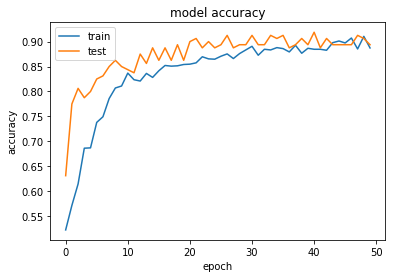

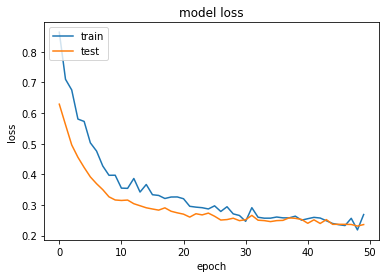

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

In [15]:
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [16]:
Y_holdout

13      1
14      0
38      1
43      0
44      0
80      0
104     1
127     0
137     0
138     1
141     1
167     1
195     1
199     0
207     1
212     0
213     1
221     0
240     0
256     0
267     1
274     1
276     1
285     1
290     0
294     0
300     1
307     1
311     1
318     1
       ..
1363    1
1364    0
1373    1
1380    1
1394    0
1411    0
1435    0
1440    1
1445    1
1447    1
1460    1
1470    0
1488    0
1495    0
1504    1
1516    0
1525    0
1533    0
1537    0
1539    0
1541    0
1542    0
1549    0
1552    0
1559    0
1566    0
1567    0
1577    0
1590    0
1602    0
Name: is_iceberg, Length: 160, dtype: int64

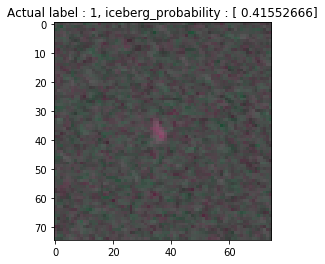

In [17]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[13])+ ","+" iceberg_probability : "+str(pred_valid[0])
plt.title(tl)

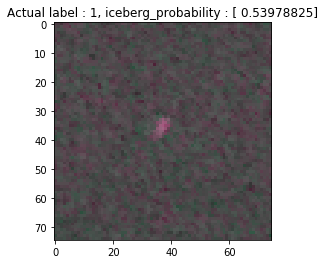

In [18]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[38])+ ","+" iceberg_probability : "+str(pred_valid[2])
plt.title(tl)

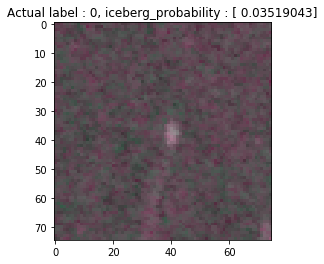

In [19]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[14])+ ","+" iceberg_probability : "+str(pred_valid[1])
plt.title(tl)

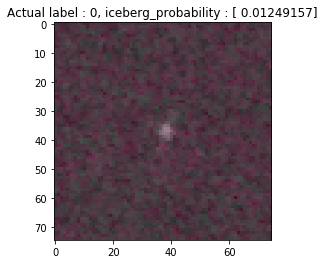

In [21]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[43])+ ","+" iceberg_probability : "+str(pred_valid[3])
plt.title(tl)

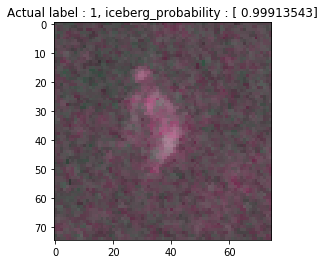

In [23]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[104])+ ","+" iceberg_probability : "+str(pred_valid[6])
plt.title(tl)

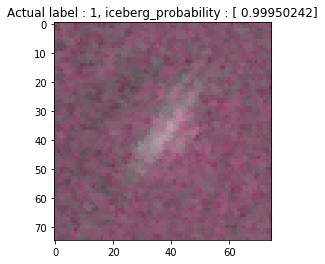

In [24]:
plt.imshow(X_holdout2[9], cmap='gray', interpolation='nearest');
tl = "Actual label : " +str(Y_holdout[138])+ ","+" iceberg_probability : "+str(pred_valid[9])
plt.title(tl)